In [9]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [10]:
dataset = pd.read_csv('./data/car_evaluation.csv')
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [11]:
column_list = []
for i in dataset.columns:
    column_list.append(i)

<AxesSubplot: ylabel='output'>

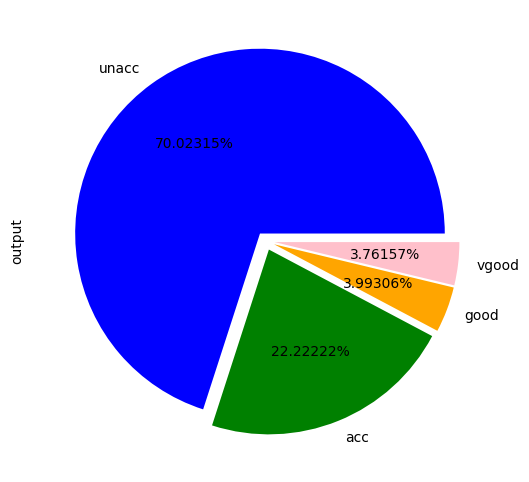

In [12]:
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 8
fig_size[1] = 6

plt.rcParams['figure.figsize'] = fig_size

dataset.output.value_counts().plot(kind='pie', autopct='%0.05f%%', colors = ['blue' , 'green' , 'orange' , 'pink'], explode = (0.05, 0.05, 0.05, 0.05))

In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         1728 non-null   object
 1   maint         1728 non-null   object
 2   doors         1728 non-null   object
 3   persons       1728 non-null   object
 4   lug_capacity  1728 non-null   object
 5   safety        1728 non-null   object
 6   output        1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [14]:
# for i in column_list:
#     dataset[i] = dataset[i].astype('category')

In [15]:
categorical_col = column_list[:-1]
output_col = column_list[-1:]

In [16]:
for idx, i in enumerate(categorical_col):
    dataset[i] = dataset[i].astype('category')
    globals()['col_{}'.format(idx)] = dataset[i].cat.codes.values

categorical_data = np.stack([col_0, col_1, col_2, col_3, col_4, col_5], axis= 1)

In [17]:
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

In [18]:
dataset.output.value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: output, dtype: int64

In [19]:
outputs = pd.get_dummies(dataset.output)
outputs = outputs.values
outputs = torch.tensor(outputs).flatten()

print(categorical_data.shape)
print(outputs.shape)

torch.Size([1728, 6])
torch.Size([6912])


In [20]:
categorical_column_sizes = [len(dataset[column].cat.categories) for column in categorical_col]
categorical_embedding_sizes = [(col_size, min(50, (col_size + 1)//2)) for col_size in categorical_column_sizes]

In [21]:
total_records = categorical_data.shape[0]
test_records = int(total_records * 0.2)

categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records : total_records]

train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records - test_records : total_records]

In [22]:
print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


In [23]:
class Model(nn.Module):
    def __init__(self, embedding_size, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical):
        embeddings = []
        for i, e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)
        x = self.layers(x)
        return x

In [24]:
model = Model(categorical_embedding_sizes, 4, [200,100,50], p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(4, 2)
    (2): Embedding(4, 2)
    (3): Embedding(3, 2)
    (4): Embedding(3, 2)
    (5): Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


In [25]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [26]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [27]:
epochs = 500
aggregated_loss = []

train_outputs = train_outputs.to(device=device, dtype=torch.int64)

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data).to(device)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_loss.append(single_loss)

    if i%25 == 1:
        print(f'epoch: {i} loss : {single_loss.item():10.5f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i} loss: {single_loss.item():10.3f}')

epoch: 1 loss :    1.52491
epoch: 26 loss :    1.37813
epoch: 51 loss :    1.28398
epoch: 76 loss :    1.19037
epoch: 101 loss :    1.06706
epoch: 126 loss :    0.94740
epoch: 151 loss :    0.82699
epoch: 176 loss :    0.73225
epoch: 201 loss :    0.67630
epoch: 226 loss :    0.64947
epoch: 251 loss :    0.63559
epoch: 276 loss :    0.61861
epoch: 301 loss :    0.62101
epoch: 326 loss :    0.60098
epoch: 351 loss :    0.58752
epoch: 376 loss :    0.59470
epoch: 401 loss :    0.58774
epoch: 426 loss :    0.56916
epoch: 451 loss :    0.57882
epoch: 476 loss :    0.56473
epoch: 500 loss:      0.575


In [28]:
test_outputs = test_outputs.to(device=device, dtype=torch.int64)

with torch.no_grad():
    y_val = model(categorical_test_data)
    loss = loss_function(y_val, test_outputs)

print(f'loss : {loss:10.3f}')

loss :      0.558


In [29]:
y_val = np.argmax(y_val, axis=1)
print(y_val[:10])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(test_outputs, y_val))
print(classification_report(test_outputs, y_val))
print(accuracy_score(test_outputs, y_val))

[[259   0]
 [ 86   0]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       259
           1       0.00      0.00      0.00        86

    accuracy                           0.75       345
   macro avg       0.38      0.50      0.43       345
weighted avg       0.56      0.75      0.64       345

0.7507246376811594


/Users/shasha/miniforge3/envs/torch_book/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shasha/miniforge3/envs/torch_book/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shasha/miniforge3/envs/torch_book/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m